# Neural network development for turbulence modeling in URANS simulations of non-Newtonian media slope flows

URANS mathematical model:
\begin{equation}
	\label{vof}
	\left\{
		\begin{aligned}
			&\boldsymbol{\nabla} \cdot \bar{\boldsymbol{u}} = 0,\\
			&\frac{\partial \bar{\alpha}}{\partial t} + \boldsymbol{\nabla} \cdot (\bar{\boldsymbol{u}} \bar{\alpha}) = 0,\\
			&\frac{\partial (\rho \bar{\boldsymbol{u}})}{\partial t} + \boldsymbol{\nabla} \cdot (\rho \bar{\boldsymbol{u}} \bar{\boldsymbol{u}}) = -\boldsymbol{\nabla} \bar{p} + \boldsymbol{\nabla} \cdot \bar{\boldsymbol{\tau}} + \rho \bar{\boldsymbol{f}}.
		\end{aligned}
	\right.
\end{equation}
Here $\bar{\boldsymbol{u}}$ is the speed of the mixture, horizontal bar means Reynolds averaging, $\bar{\alpha}$ is the volume fraction of the selected phase, $\bar{\boldsymbol{\tau}} = \bar{\boldsymbol{\tau}}_{Re} + \bar{\boldsymbol{\tau}}_m$ is the stress tensor calculated as sum of Reynolds stress tensor and viscous stress tensor, $\bar{\boldsymbol{\tau}}_m = 2 \mu \bar{\boldsymbol{s}}$ is the viscous stress tensor, which is a function of the strain rate tensor $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$, $\mu = \nu \rho$ is dynamic viscosityof a mixture which is calculated as a product of density and kinematic viscosity of mixture, $\nu = \nu_1 \bar{\alpha} + \nu_0 (1 -\bar{\alpha})$ is the kinemsatic viscosity of mixture calculated according to the principle of the weighted average, $\nu_0$ is a constant, $\nu_1 = min (\nu_*, (\tau_* + K \dot{\gamma}^n) / \dot{\gamma})$ is Herschel-Bulkley reology ratio, $\rho = \rho_1 \bar{\alpha} + \rho_0 (1 - \bar{\alpha})$ is the mixture density, $\rho_0$ and $\rho_1$ are constants, $\bar{p}$ is the pressure, $\bar{\boldsymbol{f}}$ is the density of the body forces.

The $\bar{\boldsymbol{\tau}}_{Re}$ Reynolds stress tensor is calculetaed using Tensor Basis Neural Network (TBNN) according to the principle presented in the work of Pope [1]. It is presented as function of strain rate $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ and rotation rate $\bar{\boldsymbol{r}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} - (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ tensors, and 10 their isotropic combinations $T^i$ and 5 invariants $\lambda_i$. Calculations performed for normalized tensors $\bar{\tau}_{Re}'$, $\bar{\boldsymbol{s}}'$, $\bar{\boldsymbol{r}}'$. The scaling parameters $U_0$, $h_0$, $\rho$ used for normalization:

\begin{equation}
	\label{norm}
	\left\{
		\begin{aligned}
			&\bar{\boldsymbol{\tau}}_{Re} = \bar{\boldsymbol{\tau}}_{Re}' \rho U_0 h_0,\\
			&\bar{\boldsymbol{s}} = \bar{\boldsymbol{s}}' U_0^2 / h_0,\\
			&\bar{\boldsymbol{r}} = \bar{\boldsymbol{r}}' U_0^2 / h_0.
		\end{aligned}
	\right.
\end{equation}

In what follows, we omit the apostrophe symbol and keep in mind that we are considering normalized tensors.

Normalized Reynolds stress tensor is

\begin{equation}
	\label{MLReynolds}
	\bar{\boldsymbol{\tau}}_{Re} = \sum\limits_{n=1}^{10} g^{(n)} (\lambda_1, ... , \lambda_5) \boldsymbol{T}^{(n)}.
\end{equation}

\begin{equation}
	\begin{aligned}
		&\boldsymbol{T}^{(1)} = \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(6)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} + \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \frac{2}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(2)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} - \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(7)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} \bar{\boldsymbol{r}},\\
		&\boldsymbol{T}^{(3)} = \bar{\boldsymbol{s}}^2 - \frac{1}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2),
		&&\boldsymbol{T}^{(8)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},\\
		&\boldsymbol{T}^{(4)} = \bar{\boldsymbol{r}}^2 - \frac{1}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{r}}^2),
		&&\boldsymbol{T}^{(9)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 + \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \frac{2}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(5)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
		&&\boldsymbol{T}^{(10)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
	\end{aligned}
\end{equation}
\begin{equation}
	\lambda_1 = Tr(\bar{\boldsymbol{s}}^2),\ \ \ \ \lambda_2 = Tr(\bar{\boldsymbol{r}}^2),\ \ \ \ \lambda_3 = Tr(\bar{\boldsymbol{s}}^3),\ \ \ \ \lambda_4 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}),\ \ \ \ \lambda_5 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2).
\end{equation}

Calculations performed for turbulent flow in inclined chute with the rectangular cross-section. Scheme of flow is shown in figure below.

<div>
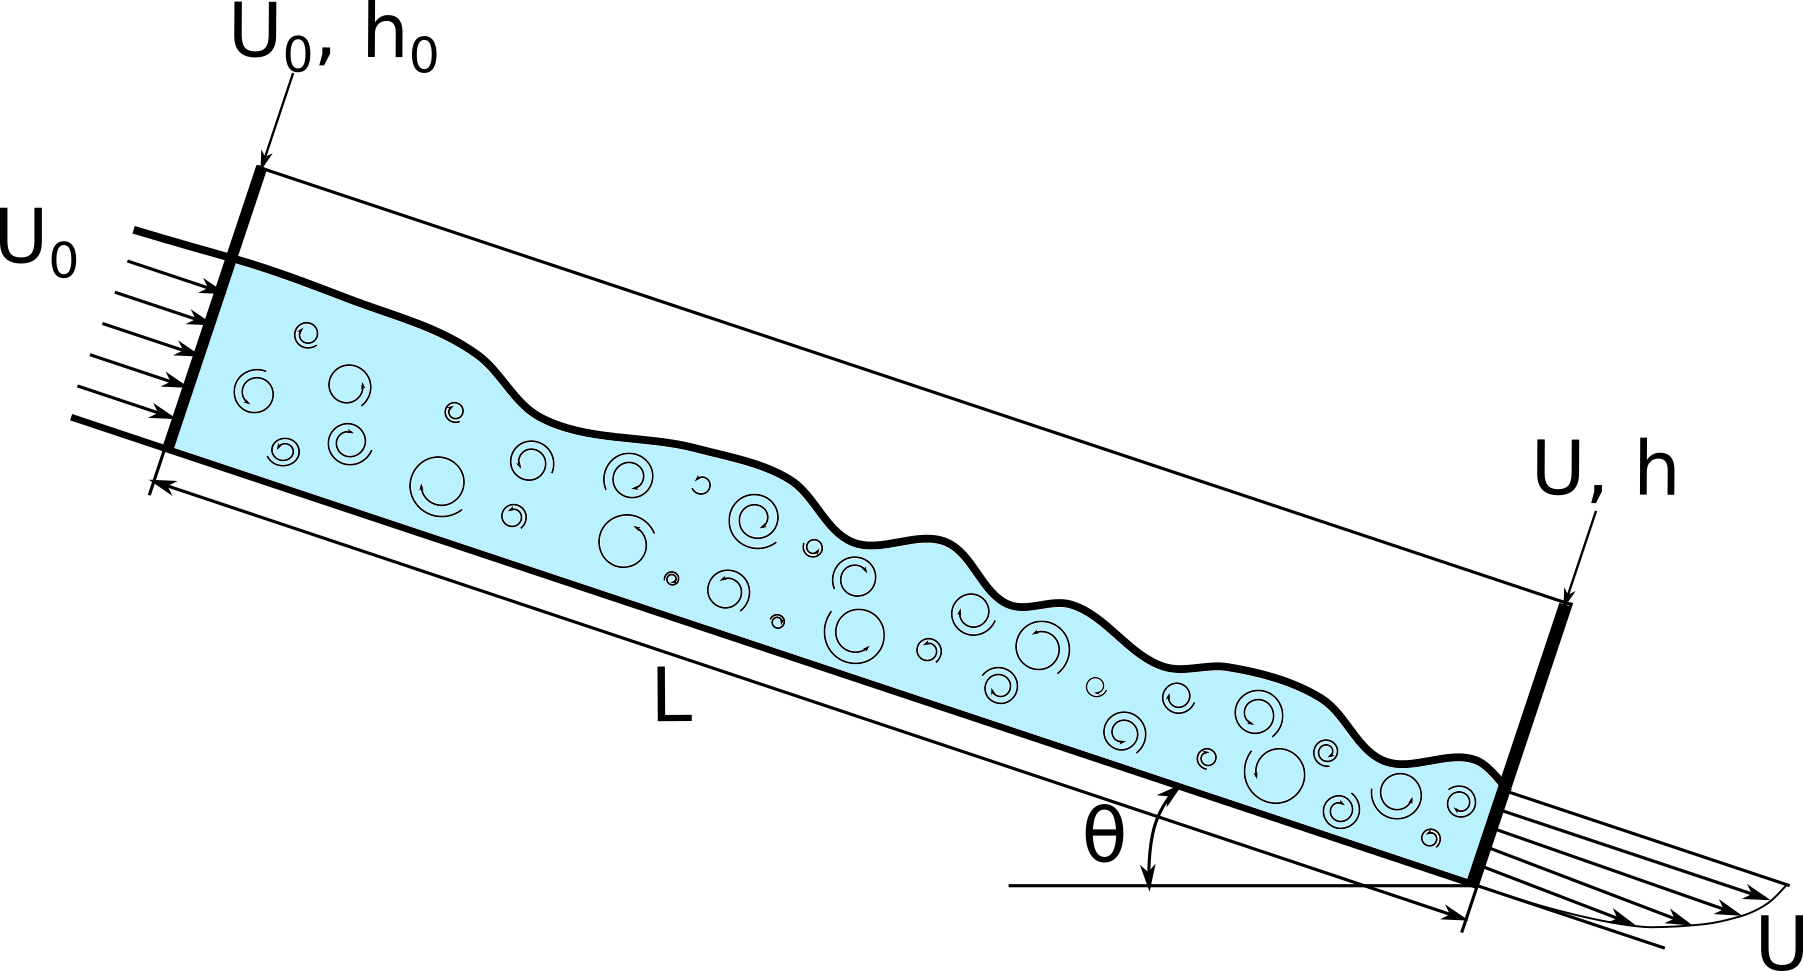
</div>

In the considered flow
\begin{equation}
    U_0 = 0.4\ \text{m}/\text{s},\ \ \ h_0 = 0.01\ \text{m},\ \ \ \theta = 25^\circ,\ \ \ L = 0.1\ \text{m}.
\end{equation}

Reynolds number of flow is 
\begin{equation}
    \text{Re} = U_0 h_0 / \nu_{eff},
\end{equation}

\begin{equation}
    \nu_{eff} = \frac{\tau_* + K (U_0/h_0)^n}{\rho (U_0 / h_0)}.
\end{equation}

Constants in calculation are set as follows:

\begin{equation}
    \nu_* = 10^7\ \text{m}^2/\text{s},\ \ \ \tau_* = 2 \cdot 10^{-3}\ \text{m}^2/\text{s}^2,\ \ \ K = 10^{-4}\ \text{m}^2/\text{s},\ \ \ n = 0.8,\ \ \ \rho = 100\ \text{kg}/\text{m}^3.
\end{equation}

So effective viscosity and Reynolds number are:

\begin{equation}
    \nu_{eff} = 10^{-6}\ \text{m}^2/\text{s},\ \ \ \text{Re} = 4000.
\end{equation}

The mesh cell linear size must be $dx = \frac{h_0}{\text{Re}^{3/4}} = 2 \cdot 10^{-5}$. Time step $dt = 5 \cdot 10^{-5}$.

Mesh size for computational domain size of 0.1x0.011x0.002 m$^3$ is $27.5 \cdot 10^7$.

[1] S. B. Pope. A more general effective-viscosity hypothesis.Journal of Fluid Mechanics,72(2):331–340, 1975.

## Current research

Above was global formulation for TBNN (Tensor Based Neural Network) with implemengtation into mathematical model. Now let's try to realize ML-turbulence model as a correction step for variables $\bar{\boldsymbol{u}}$, $\bar{\alpha}$, $\bar{p}$.

Will use tensors $\boldsymbol{T}^{(i)}$, invariants $\lambda_i$ and variables $\bar{\boldsymbol{u}}$, $\bar{p}$, $\bar{\alpha}$ as a features of NN (Neural Network). As a targets will be the differenses between DNS and RANS values for $\boldsymbol{u}$, $\alpha$ and $p$.

Let's start with importing libraries.

In [112]:
#!pip install git+https://github.com/tensorflow/docs
#!pip install -q -U keras-tuner
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
#!pip install pyyaml h5py

In [113]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
import subprocess as sp
import fileinput as fi
from keras.utils.vis_utils import plot_model

print(tf.__version__)

2.7.0


In [3]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype(np.float))
    timeStepsList = timeStepsList[index]
    #return np.asarray(timeStepsList[1:-2], dtype=str)
    return timeStepsList[1:-2]

In [4]:
def readTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [5]:
def readSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr[[fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'8']]

In [6]:
def readVector(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [7]:
def readScalar(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.columns = [fileName[0]]
    arr.loc[:] = arr.loc[:].astype(float)
    return arr

In [8]:
def prepareLabels(data):
    data['dU0'] = data['res/Uref0'] - data['res/U0']
    data['dU1'] = data['res/Uref1'] - data['res/U1']
    data['dU2'] = data['res/Uref2'] - data['res/U2']
    data['dAW'] = data['res/AWref'] - data['res/alpha.water']
    data['dp'] = data['res/p_rghref'] - data['res/p_rgh']

In [147]:
def prepareInit(fullData):
    data = fullData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
    data['dU0'] = fullData['dU0'] / fullData['res/Uref0']
    data['dU1'] = fullData['dU1'] / fullData['res/Uref1']
    data['dU2'] = fullData['dU2'] / fullData['res/Uref2']
    data['dAW'] = fullData['dAW'] / fullData['res/AWref']
    data['dp'] = fullData['dp'] / fullData['res/p_rghref']
    return data

In [152]:
def preparePrediction(dataPredicted, fullData):
    data = dataPredicted.copy()
    data['dU0'] = (fullData['dU0'] - dataPredicted['dU0']) / fullData['res/Uref0']
    data['dU1'] = (fullData['dU1'] - dataPredicted['dU1']) / fullData['res/Uref1']
    data['dU2'] = (fullData['dU2'] - dataPredicted['dU2']) / fullData['res/Uref2']
    data['dAW'] = (fullData['dAW'] - dataPredicted['dAW']) / fullData['res/AWref']
    data['dp'] = (fullData['dp'] - dataPredicted['dp']) / fullData['res/p_rghref']
    return data

In [10]:
def formDataset(TSL, TSLlen, folder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size):
    data = pd.DataFrame()
    for time in TSL:
        if TSLlen == 1:
            time = TSL
        kwargs = {'folder':folder, 'time':time, 'sz':size}
        scalars = FsScalars.apply(readScalar, axis=1, **kwargs)
        vectors = FsVectors.apply(readVector, axis=1, **kwargs)
        tensors = FsTensors.apply(readTensor, axis=1, **kwargs)
        symmTensors = FsSymmTensors.apply(readSymmTensor, axis=1, **kwargs)
        tmp = pd.concat(list(scalars[:])+list(vectors[:])+list(tensors[:])+list(symmTensors[:]), axis=1)
        data = data.append(tmp, ignore_index=True)
        prepareLabels(data)
        if TSLlen == 1:
            break
    return data

In [11]:
def writePrediction(arr, arrType, time, folder, fileName):
    sp.run('cp '+folder+time+'/patterns/'+fileName+'PatternBeginning '+folder+time+'/'+ time+'/'+fileName, shell=True, check=True)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as f:
        f.write(str(len(arr))+'\n(\n')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('folderName', '"'+time+'"'), end='')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('fieldName', fileName), end='')
    if arrType == 'vector':
        arr = arr.astype(str)
        arr = '( '+arr.iloc[:,0]+' '+arr.iloc[:,1]+' '+arr.iloc[:,2]+' )'
    elif arrType == 'scalar':
        arr = arr.astype(str)
    arr.to_csv(folder+time+'/'+time+'/'+fileName, mode='a', index=False, header=False)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as\
        fout, fi.input(folder+time+'/'+'patterns/'+fileName+'PatternEnding') as fin:
            for line in fin:
                fout.write(line)

In [12]:
#writePrediction(testLastData[['dU0', 'dU1', 'dU2']], 'vector', testLastTSL, MLturbRANSfolder ,'dU')
#writePrediction(testLastData[['dp']], 'scalar', testLastTSL, MLturbRANSfolder ,'dp')

Below all fiatures listed. alpha.water is $\bar{\alpha}$, 'alpha.water', 'U' and 'p_rgh' are initial values. Parameters from res/ folder are calculated without turbulence model using base interFoam solver. 'Uref', 'AWref' and 'p_rghref' are reference values calculated using DNS data.

In [13]:
TSL = timeStepsList()
testTSL = TSL[[int(len(TSL)/2), -1]]
testCenterTSL = TSL[int(len(TSL)/2)]
testLastTSL = TSL[-1]
TSL = np.delete(TSL, [int(len(TSL)/2), -1])
TSL = TSL[:3]
lenTSL = len(TSL)
MLturbRANSfolder = 'TIF'
KEturbRANSfolder = 'KEIF'
KWturbRANSfolder = 'KWIF'
deltaT = 1e-06
size = 300000
FsScalars = pd.DataFrame([['alpha.water'], ['res/alpha.water'], ['res/AWref'], ['p_rgh'], ['res/p_rgh'],\
                          ['res/p_rghref']])#, ['res/I0'], ['res/I1'], ['res/I2'], ['res/I3'], ['res/I4']])
FsVectors = pd.DataFrame([['U'], ['res/U'], ['res/Uref'], ['res/gradP'], ['res/gradAW']])
FsTensors = pd.DataFrame([['res/rotationRateTensor']])
FsSymmTensors = pd.DataFrame([['res/T0']])#, ['res/T1'], ['res/T2'], ['res/T3'], ['res/T4'], ['res/T5'], \
                          #['res/T6'], ['res/T7'], ['res/T8'], ['res/T9']])
ResFsScalars = pd.DataFrame([['res/alpha.water'], ['res/AWref'], ['res/p_rgh'], ['res/p_rghref']])
ResFsVectors = pd.DataFrame([['res/U'], ['res/Uref']])
ResFsTensors = pd.DataFrame()
ResFsSymmTensors = pd.DataFrame()

In [14]:
trainData = formDataset(TSL, len(TSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
testData = formDataset(testTSL, len(testTSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
testCenterData = formDataset(testCenterTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
testLastData = formDataset(testLastTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)

testKEData = formDataset(testTSL, len(testTSL), KEturbRANSfolder, ResFsScalars, ResFsVectors,
                         ResFsTensors, ResFsSymmTensors, size)
testKECenterData = formDataset(testCenterTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
                               ResFsTensors, ResFsSymmTensors, size)
testKELastData = formDataset(testLastTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
                             ResFsTensors, ResFsSymmTensors, size)

testKWData = formDataset(testTSL, len(testTSL), KWturbRANSfolder, ResFsScalars, ResFsVectors,
                         ResFsTensors, ResFsSymmTensors, size)
testKWCenterData = formDataset(testCenterTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
                               ResFsTensors, ResFsSymmTensors, size)
testKWLastData = formDataset(testLastTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
                             ResFsTensors, ResFsSymmTensors, size)

trainData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alpha.water,900000.0,3.334008e-01,0.467546,-5.246782e-08,3.563767e-34,4.955454e-10,1.000000e+00,1.000000e+00
res/alpha.water,900000.0,3.334341e-01,0.467557,-5.940444e-10,6.127791e-34,5.243630e-10,1.000000e+00,1.000000e+00
res/AWref,900000.0,3.334341e-01,0.467559,-4.906264e-08,3.397701e-34,4.899232e-10,1.000000e+00,1.000000e+00
p_rgh,900000.0,-2.025066e+01,65.875068,-3.656183e+02,-3.259992e-01,-1.798588e-03,1.506109e-02,8.674894e+01
res/p_rgh,900000.0,-2.350081e+01,64.175347,-3.795516e+02,-2.123459e+00,-1.241578e+00,-2.663516e-01,8.690888e+01
res/p_rghref,900000.0,-2.025747e+01,65.889468,-3.654169e+02,-3.257017e-01,-1.886538e-03,1.467709e-02,8.679031e+01
U0,900000.0,3.069326e-01,0.331273,-3.328387e-01,2.665260e-02,1.741986e-01,5.459567e-01,1.523512e+00
U1,900000.0,2.137406e-06,0.000958,-5.889421e-02,-6.171424e-06,-4.550673e-08,3.425369e-06,6.039165e-02
U2,900000.0,1.853664e-02,0.083812,-2.074183e-01,-2.943756e-02,-4.180084e-03,6.129330e-02,1.020001e+00
res/U0,900000.0,3.070660e-01,0.331243,-3.335009e-01,2.632982e-02,1.746257e-01,5.461099e-01,1.518591e+00


In [15]:
train_features = trainData.copy()
train_labels = train_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
train_features = train_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp',\
                                      'res/Uref0', 'res/Uref1', 'res/Uref2', 'res/p_rghref', 'res/AWref'],\
                                     axis=1)

test_features = testData.copy()
test_labels = test_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
test_features = test_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp',\
                                      'res/Uref0', 'res/Uref1', 'res/Uref2', 'res/p_rghref', 'res/AWref'],\
                                     axis=1)

test_center_features = testCenterData.copy()
test_center_labels = test_center_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
test_center_features = test_center_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp',\
                                      'res/Uref0', 'res/Uref1', 'res/Uref2', 'res/p_rghref', 'res/AWref'],\
                                     axis=1)

test_last_features = testLastData.copy()
test_last_labels = test_last_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
test_last_features = test_last_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp',\
                                      'res/Uref0', 'res/Uref1', 'res/Uref2', 'res/p_rghref', 'res/AWref'],\
                                     axis=1)

In [156]:
test_center_features[['res/U0', 'res/U1', 'res/U2', 'res/alpha.water', 'res/p_rgh']].describe().T

,count,mean,std,min,25%,50%,75%,max
res/U0,300000.0,0.307575,0.331243,-3.382485e-01,2.642836e-02,1.761661e-01,0.546436,1.509951
res/U1,300000.0,0.000003,0.000768,-6.112823e-02,-7.286175e-06,-4.198488e-08,0.000006,0.067077
res/U2,300000.0,0.018189,0.083786,-2.084273e-01,-2.955407e-02,-4.570416e-03,0.060848,1.018391
res/alpha.water,300000.0,0.333701,0.467661,-1.147922e-09,6.521325e-34,5.270683e-10,1.000000,1.000000
res/p_rgh,300000.0,-23.530322,64.283370,-3.824621e+02,-2.035515e+00,-1.215150e+00,-0.261515,86.904670


In [153]:
test_center_labels.describe().T

,count,mean,std,min,25%,50%,75%,max
dU0,300000.0,-6.051112e-05,0.000891,-0.101982,-1.094628e-04,4.475000e-06,3.110720e-04,0.052873
dU1,300000.0,-8.187673e-07,0.000359,-0.026215,-2.075703e-06,-7.166240e-09,1.527862e-06,0.028263
dU2,300000.0,-2.974029e-05,0.000923,-0.049631,-8.290335e-05,1.727744e-06,8.608672e-05,0.107957
dAW,300000.0,-1.190863e-08,0.000336,-0.017212,-2.968942e-44,0.000000e+00,1.034687e-28,0.017907
dp,300000.0,3.221613e+00,8.264953,-47.305968,5.454328e-01,1.180948e+00,1.832533e+00,73.677609


In [154]:
prepareInit(testCenterData).describe().T

,count,mean,std,min,25%,50%,75%,max
dU0,300000.0,1.385279e-02,2.302929e+00,-6.688630e+02,-0.000004,0.000094,0.008868,3.906917e+02
dU1,300000.0,9.518609e-01,8.155855e+02,-1.424351e+05,-0.246424,0.046728,0.259457,2.968857e+05
dU2,300000.0,-3.929602e-03,2.017741e+00,-3.423093e+02,-0.005147,-0.000640,0.000039,4.347257e+02
dAW,300000.0,-1.227034e+06,4.371261e+08,-1.807286e+11,-0.000519,0.000000,0.001394,7.163778e+06
dp,300000.0,-3.281883e+02,1.735619e+05,-8.888377e+07,-8.736882,-0.004166,18.167688,1.489178e+07


In [16]:
N_VALIDATION = len(test_features)
print(N_VALIDATION)
N_TRAIN = len(train_features)
print(N_TRAIN)
BUFFER_SIZE = N_TRAIN
print(BUFFER_SIZE)
BATCH_SIZE = 5000
print(BATCH_SIZE)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)
N_LABELS = len(train_labels.columns)
print(N_LABELS)

600000
900000
900000
5000
180
5


In [103]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*10,
    decay_rate=1,
    staircase=False)

lr_scheduleLn = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*10,
    decay_rate=1,
    staircase=False)

def get_optimizer(lr_schedule=lr_schedule):
    return tf.keras.optimizers.Adam(lr_scheduleLn)

In [105]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.MeanAbsoluteError(
                      name='mean_absolute_error')])

    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.2,
        verbose=1)
    return history

In [116]:
class lnPlus(layers.Layer):
    def __init__(self, units=32):
        super(lnPlus, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(tf.math.log(tf.maximum(inputs, 1e-10)), self.w) + self.b
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "w": self.w,
            "b": self.b,
        })
        return config
    
class lnMinus(layers.Layer):

    def __init__(self, units=32):
        super(lnMinus, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(tf.math.log(tf.maximum(-inputs, 1e-10)), self.w) + self.b
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "w": self.w,
            "b": self.b,
        })
        return config

In [107]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [117]:
inputs = keras.Input(shape=(len(train_features.columns),))
norm = normalizer(inputs)
lnMinusLayer = lnMinus(64)(inputs)
lnPlusLayer = lnPlus(64)(inputs)
lns = layers.concatenate([lnMinusLayer, lnPlusLayer])
multiplication = layers.Dense(64, activation='exponential')(lns)
normMultiplication = layers.LayerNormalization(axis=1)(multiplication)
linMembers = layers.concatenate([norm, normMultiplication])
denseLayer1 = layers.Dense(64)(linMembers)
#denseLayer2 = layers.Dense(64)(denseLayer1)
#denseLayer3 = layers.Dense(64)(denseLayer2)
outputs = layers.Dense(len(train_labels.columns))(denseLayer1)
lnModel = keras.Model(
    inputs=inputs,
    outputs=outputs,
)

In [23]:
#inputs = keras.Input(shape=(len(train_features.columns),))
#norm = normalizer(inputs)
#lnMinusLayer = lnMinus(norm)
#lnPlusLayer = lnPlus(norm)
#lns = layers.concatenate([lnMinusLayer, lnPlusLayer], axis=1)
#multiplication = layers.Dense(64, activation='exponential')(lns)
#linMembers = layers.concatenate([multiplication, lnMinusLayer, lnPlusLayer])
#denseLayer1 = layers.Dense(64)(linMembers)
#denseLayer2 = layers.Dense(64)(denseLayer1)
#denseLayer3 = layers.Dense(64)(denseLayer2)
#outputs = layers.Dense(len(train_labels.columns))(denseLayer3)
#model = keras.Model(
#    inputs=inputs,
#    outputs=outputs,
#)

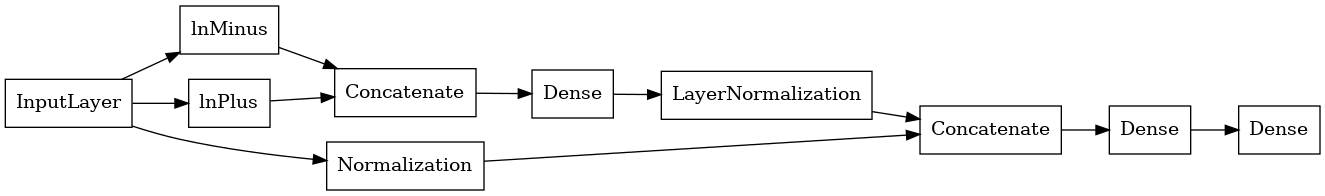

In [90]:
keras.utils.plot_model(lnModel, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')

In [25]:
histories = {}

In [109]:
%%time
histories['lnModel'] = compile_and_fit(
    lnModel,
    'lnModel',
    max_epochs=50)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 36)]         0           []                               
                                                                                                  
 ln_minus_14 (lnMinus)          (None, 64)           2368        ['input_15[0][0]']               
                                                                                                  
 ln_plus_14 (lnPlus)            (None, 64)           2368        ['input_15[0][0]']               
                                                                                                  
 concatenate_28 (Concatenate)   (None, 128)          0           ['ln_minus_14[0][0]',            
                                                                  'ln_plus_14[0][0]']      

180/180 [==============================] - 20s 114ms/step - loss: 0.5039 - mean_absolute_error: 0.5039 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785
Epoch 33/50
180/180 [==============================] - 20s 114ms/step - loss: 0.5037 - mean_absolute_error: 0.5037 - val_loss: 0.2783 - val_mean_absolute_error: 0.2783
Epoch 34/50
180/180 [==============================] - 20s 113ms/step - loss: 0.5034 - mean_absolute_error: 0.5034 - val_loss: 0.2784 - val_mean_absolute_error: 0.2784
Epoch 35/50
180/180 [==============================] - 20s 114ms/step - loss: 0.5032 - mean_absolute_error: 0.5032 - val_loss: 0.2781 - val_mean_absolute_error: 0.2781
Epoch 36/50
180/180 [==============================] - 20s 113ms/step - loss: 0.5030 - mean_absolute_error: 0.5030 - val_loss: 0.2778 - val_mean_absolute_error: 0.2778
Epoch 37/50
180/180 [==============================] - 20s 114ms/step - loss: 0.5028 - mean_absolute_error: 0.5028 - val_loss: 0.2777 - val_mean_absolute_error: 0.2777
Epoc

In [119]:
#!mkdir -p saved_model
lnModel.save('lnModel.h5')
#lnModel = load_model('lnModel')

TypeError: Unable to serialize <tf.Variable 'ln_minus_15/Variable:0' shape=(36, 64) dtype=float32, numpy=
array([[-0.0833184 , -0.06133591,  0.02765931, ...,  0.04398571,
         0.03473502, -0.06662583],
       [ 0.05282043,  0.0395814 , -0.02965362, ...,  0.05201409,
         0.05697683,  0.00399297],
       [-0.02559911,  0.04773375, -0.00312742, ...,  0.00512388,
        -0.12757829, -0.02427237],
       ...,
       [-0.05404904,  0.06321349, -0.01389136, ...,  0.00329278,
        -0.05981505,  0.01845661],
       [ 0.04356384, -0.06871656, -0.0223246 , ...,  0.08551314,
        -0.01880116,  0.09944876],
       [-0.0172417 , -0.02423197,  0.0533853 , ...,  0.00517682,
        -0.04695573,  0.02941988]], dtype=float32)> to JSON. Unrecognized type <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>.

In [27]:
full_dnn_model_1 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [28]:
%%time
histories['full_dnn_model_1'] = compile_and_fit(
    full_dnn_model_1,
    'full_dnn_model_1',
    max_epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                2368      
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,766
Trainable params: 2,693
Non-trainable params: 73
_________________________________________________________________
Epoch 1/50
180/180 [==============================] - 13s 70ms/step - loss: 0.5924 - mean_absolute_error: 0.5924 - val_loss: 0.2802 - val_mean_absolute_error: 0.2802
Epoch 2/50
180/180 [==============================] - 13s 70ms/step - loss: 0.4499 - 

Epoch 45/50
180/180 [==============================] - 12s 67ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 46/50
180/180 [==============================] - 12s 67ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 47/50
180/180 [==============================] - 12s 67ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 48/50
180/180 [==============================] - 12s 69ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - val_loss: 0.0419 - val_mean_absolute_error: 0.0419
Epoch 49/50
180/180 [==============================] - 12s 67ms/step - loss: 0.0438 - mean_absolute_error: 0.0438 - val_loss: 0.0408 - val_mean_absolute_error: 0.0408
Epoch 50/50
180/180 [==============================] - 12s 67ms/step - loss: 0.0429 - mean_absolute_error: 0.0429 - val_loss: 0.0399 - val_mean_absolute_error: 0.039

In [29]:
full_dnn_model_2 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [30]:
%%time
histories['full_dnn_model_2'] = compile_and_fit(
    full_dnn_model_2,
    'full_dnn_model_2',
    max_epochs=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                2368      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6,926
Trainable params: 6,853
Non-trainable params: 73
_________________________________________________________________
Epoch 1/50
180/180 [==============================] - 14s 76ms/step - loss: 0.5742 - mean_absolute_error: 0.5742 - va

180/180 [==============================] - 13s 74ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 45/50
180/180 [==============================] - 13s 74ms/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 46/50
180/180 [==============================] - 13s 73ms/step - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 47/50
180/180 [==============================] - 13s 72ms/step - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162
Epoch 48/50
180/180 [==============================] - 13s 74ms/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161
Epoch 49/50
180/180 [==============================] - 13s 73ms/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160
Epoch 50/5

In [31]:
full_dnn_model_3 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [32]:
%%time
histories['full_dnn_model_3'] = compile_and_fit(
    full_dnn_model_3,
    'full_dnn_model_3',
    max_epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                2368      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 11,086
Trainable params: 11,013
Non-trainable params: 73
_________________________________________________

180/180 [==============================] - 16s 87ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 44/50
180/180 [==============================] - 14s 78ms/step - loss: 0.0182 - mean_absolute_error: 0.0182 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 45/50
180/180 [==============================] - 14s 78ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 46/50
180/180 [==============================] - 14s 79ms/step - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 47/50
180/180 [==============================] - 14s 78ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 48/50
180/180 [==============================] - 14s 78ms/step - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 49/5

In [33]:
full_dnn_model_4 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [34]:
%%time
histories['full_dnn_model_4'] = compile_and_fit(
    full_dnn_model_4,
    'full_dnn_model_4',
    max_epochs=50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense_12 (Dense)            (None, 64)                2368      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 5)                 325       
                                                      

180/180 [==============================] - 15s 83ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 43/50
180/180 [==============================] - 15s 84ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 44/50
180/180 [==============================] - 15s 83ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 45/50
180/180 [==============================] - 15s 83ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 46/50
180/180 [==============================] - 15s 83ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 47/50
180/180 [==============================] - 15s 83ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 48/5

(0.0, 0.5)

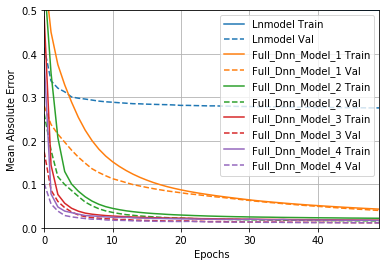

In [120]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

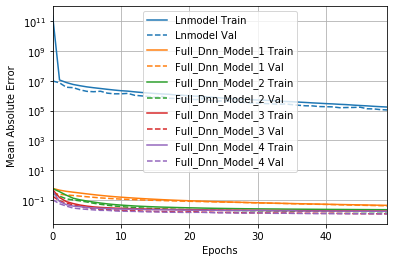

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

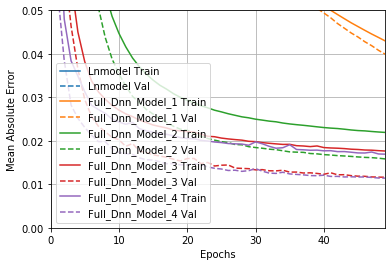

In [37]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [44]:
full_dnn_models = {}
full_dnn_models['full_dnn_model_1'] = full_dnn_model_1.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_2'] = full_dnn_model_2.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_3'] = full_dnn_model_3.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_4'] = full_dnn_model_4.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['lnModel'] = lnModel.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [45]:
pd.DataFrame(full_dnn_models).T

,0,1
full_dnn_model_1,0.042459,0.042459
full_dnn_model_2,0.022484,0.022484
full_dnn_model_3,0.019244,0.019244
full_dnn_model_4,0.019539,0.019539
lnModel,155224.828125,155224.828125


In [136]:
%%time
full_dnn_model_3_prediction = pd.DataFrame(
    data=full_dnn_model_3.predict(test_center_features),
    columns=test_center_labels.columns)
full_dnn_model_3_prediction

CPU times: user 35.6 s, sys: 4 s, total: 39.6 s
Wall time: 26.5 s


,dU0,dU1,dU2,dAW,dp
0,-0.036899,0.020262,0.002596,-0.020112,36.790131
1,-0.021117,0.020859,-0.003560,-0.004726,40.489979
2,-0.009779,0.023964,-0.001510,0.002281,42.461395
3,-0.003624,0.027665,0.001177,0.005090,43.109577
4,0.001164,0.029330,0.002864,0.006625,43.336834
...,...,...,...,...,...
299995,0.001340,0.000374,-0.000584,0.000210,1.226637
299996,0.000924,0.000868,-0.001049,0.000037,1.209530
299997,0.000799,0.001026,-0.001236,0.000030,1.197012
299998,0.000595,0.001197,-0.001477,0.000063,1.195541


In [148]:
full_dnn_model_3_prediction_prepared = preparePrediction(full_dnn_model_3_prediction, testCenterData)
writePrediction(full_dnn_model_3_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
writePrediction(full_dnn_model_3_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
writePrediction(full_dnn_model_3_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

testKECenterDataPrepared = prepareInit(testKECenterData)
writePrediction(testKECenterDataPrepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KEturbRANSfolder ,'dU')
writePrediction(testKECenterDataPrepared[['dp']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dp')
writePrediction(testKECenterDataPrepared[['dAW']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dAW')

testKWCenterDataPrepared = prepareInit(testKWCenterData)
writePrediction(testKWCenterDataPrepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KWturbRANSfolder ,'dU')
writePrediction(testKWCenterDataPrepared[['dp']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dp')
writePrediction(testKWCenterDataPrepared[['dAW']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dAW')

print(testCenterTSL)

0.1001


In [151]:
full_dnn_model_3_prediction_prepared.describe().T

,count,mean,std,min,25%,50%,75%,max
dU0,300000.0,5.166963e-03,3.374221e+00,-1.317883e+03,-0.002491,0.000764,7.704825e-03,5.447190e+02
dU1,300000.0,1.094757e+04,5.872444e+06,-5.759393e+08,-106.634808,0.596870,1.268948e+02,2.826874e+09
dU2,300000.0,3.199552e-01,1.965430e+02,-2.804750e+04,-0.015100,0.000511,2.695433e-02,6.439574e+04
dAW,300000.0,1.831464e+181,inf,-6.033523e+179,-0.034701,0.001699,6.339622e+12,2.914693e+186
dp,300000.0,-2.171844e+01,7.409715e+03,-3.884437e+06,-0.235049,0.000125,5.961525e-01,4.413043e+05


In [58]:
def model_optimizer(hp):
    hp_unitsLn = hp.Int('unitsLn', min_value=8, max_value=80, step=8)
    hp_unitsM = hp.Int('unitsM', min_value=8, max_value=80, step=8)
    hp_units1 = hp.Int('units1', min_value=8, max_value=80, step=8)
    hp_units2 = hp.Int('units2', min_value=8, max_value=80, step=8)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_activation = hp.Choice('activation', values=['elu', 'relu', 'None'])
    
    inputs = keras.Input(shape=(len(train_features.columns),))
    norm = normalizer(inputs)
    lnMinusLayer = lnMinus(units=hp_unitsLn)(norm)
    lnPlusLayer = lnPlus(units=hp_unitsLn)(norm)
    lns = layers.concatenate([lnMinusLayer, lnPlusLayer])
    multiplication = layers.Dense(units=hp_unitsM, activation='exponential')(lns)
    limMembers = layers.concatenate([norm, multiplication])
    denseLayer1 = layers.Dense(units=hp_units1, activation=hp_activation)(limMembers)
    denseLayer2 = layers.Dense(units=hp_units2, activation=hp_activation)(denseLayer1)
    outputs = layers.Dense(len(train_labels.columns), activation=hp_activation)(denseLayer2)
    lnModelHp = keras.Model(
        inputs=inputs,
        outputs=outputs,
    )
    
    lnModelHp.compile(#optimizer=get_optimizer(),
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_absolute_error',
        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error')])
    return lnModelHp

In [59]:
tuner = kt.Hyperband(model_optimizer,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
%%time
tuner.search(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2,
    callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit
CPU times: user 4.12 ms, sys: 0 ns, total: 4.12 ms
Wall time: 3.21 ms


In [62]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the logarithmic
layer is {best_hps.get('unitsLn')}, the optimal number of units in the multiplication densely-connected
layer is {best_hps.get('unitsM')}, the optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
layer is {best_hps.get('units2')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal activation function
is {best_hps.get('activation')}.
""")

KeyError: 'unitsLn does not exist.'

In [ ]:
lnModelHpBest = tuner.hypermodel.build(best_hps)
history_full_dnn_3_units_lr = full_dnn_3_units_lr.fit(
    train_features,
    train_labels,
    epochs=300,
    validation_split=0.2)